In [1]:
import numpy as np
import pandas as pd
import pickle
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from matplotlib import pyplot
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
%matplotlib inline

### Data Preparation

In [2]:
# loading full dataframe
final_df = pd.read_csv('final_df.csv')

In [3]:
# checking for null values
final_df.isna().sum()

title               1
artist              1
track_id            0
genre               0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
dtype: int64

In [4]:
# dropping null values
final_df.dropna(inplace=True)

In [5]:
# resetting index
final_df.reset_index(drop=True, inplace=True)

### Handling Data Imbalance Through Upsampling

In [6]:
genre_count = final_df['genre'].value_counts()
genre_count

house        1285
pop          1057
rock          995
country       747
metal         685
hiphop        680
techno        547
dance         522
jazz          487
kpop          397
classical     276
rnb           238
Name: genre, dtype: int64

In [7]:
# setting a minimum number of sample for main genres - house, pop, rock, country, hiphop, techno, dance, rnb
min_main_genre_count = 800

In [8]:
# setting a minimum number of sample for minor genres - metal, jazz, kpop, classical
min_minor_genre_count = 300

In [9]:
# genres with samples more than min_main_genre_count
genre_count[genre_count > min_main_genre_count].index

Index(['house', 'pop', 'rock'], dtype='object')

In [10]:
# retaining data for genres with samples more than min_main_genre_count
genre_house = final_df[final_df['genre'] == 'house']
genre_pop = final_df[final_df['genre'] == 'pop']
genre_rock = final_df[final_df['genre'] == 'rock']

In [11]:
# genres with samples less than min_main_genre_count
genre_count[genre_count < min_main_genre_count].index

Index(['country', 'metal', 'hiphop', 'techno', 'dance', 'jazz', 'kpop',
       'classical', 'rnb'],
      dtype='object')

In [12]:
# upsampling data for main genres with samples less than min_main_genre_count (excluding metal, jazz, kpop and cl)
genre_country = final_df[final_df['genre']=='country'].sample(min_main_genre_count, replace=True)
genre_hiphop = final_df[final_df['genre']=='hiphop'].sample(min_main_genre_count, replace=True)
genre_techno = final_df[final_df['genre']=='techno'].sample(min_main_genre_count, replace=True)
genre_dance = final_df[final_df['genre']=='dance'].sample(min_main_genre_count, replace=True)
genre_rnb = final_df[final_df['genre']=='rnb'].sample(min_main_genre_count, replace=True)

In [13]:
# genres with samples less than min_minor_genre_count
genre_count[genre_count < min_minor_genre_count].index

Index(['classical', 'rnb'], dtype='object')

In [14]:
# upsampling data for minor genres with samples less than min_minor_genre_count
genre_jazz = final_df[final_df['genre']=='jazz'].sample(min_minor_genre_count, replace=True)
genre_classical = final_df[final_df['genre']=='classical'].sample(min_minor_genre_count, replace=True)

In [15]:
# downsampling data for minor genres with samples more than min_minor_genre_count
genre_metal = final_df[final_df['genre']=='metal'].sample(min_minor_genre_count, replace=True)
genre_kpop = final_df[final_df['genre']=='kpop'].sample(min_minor_genre_count, replace=True)

In [16]:
# concatetnating all genre dataframes after upsampling
upsampled_df = pd.concat([genre_house, genre_pop, genre_rock, genre_country, genre_metal, genre_hiphop, genre_techno, genre_dance, genre_jazz,  genre_kpop, genre_classical, genre_rnb], axis=0)

In [17]:
# calculating supposed total numbers of tracks after upsampling
genre_count[genre_count > min_main_genre_count].values.sum()+len(genre_count[genre_count < min_main_genre_count].index)*min_main_genre_count-4*min_minor_genre_count

9337

In [18]:
# checking total numbers of tracks in new dataframe
len(upsampled_df)

8537

In [19]:
# resetting index
upsampled_df.reset_index(drop=True, inplace=True)

### Clustering
#### Scaling Data

In [20]:
# creating a dataframe for only audio features
X = upsampled_df.drop(columns=['title','artist', 'genre', 'track_id'])

In [21]:
# scaling the audio features dataframe
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns = X.columns)
display(X.head())
print()
display(X_scaled_df.head())

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.721,0.923,11,-4.497,0,0.0370,0.00299,0.03120,0.0989,0.575,128.748
1,0.805,0.660,5,-11.972,0,0.0897,0.01790,0.29500,0.3340,0.147,133.002
2,0.722,0.990,7,-5.103,1,0.0667,0.02090,0.00186,0.2620,0.398,122.991
3,0.691,0.830,0,-9.189,1,0.0450,0.06010,0.75800,0.4050,0.830,128.912
4,0.761,0.808,11,-5.629,0,0.0518,0.00258,0.00003,0.0869,0.157,119.931


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.535528,0.974013,1.559181,0.715240,-1.179257,-0.599530,-0.645570,-0.482648,-0.540528,0.193998,0.279226
1,1.061810,-0.193618,-0.109736,-0.881097,-1.179257,0.022696,-0.588762,0.341460,0.992266,-1.561228,0.445781
2,0.541793,1.271471,0.446570,0.585825,0.847992,-0.248864,-0.577332,-0.574306,0.522844,-0.531878,0.053825
3,0.347570,0.561125,-1.500501,-0.286768,0.847992,-0.505074,-0.427978,1.787867,1.455168,1.239751,0.285647
4,0.786138,0.463452,1.559181,0.473494,-1.179257,-0.424787,-0.647132,-0.580024,-0.618765,-1.520218,-0.065981


#### Elbow Method

Training a K-Means model with 8 clusters! 

Training a K-Means model with 9 clusters! 

Training a K-Means model with 10 clusters! 

Training a K-Means model with 11 clusters! 

Training a K-Means model with 12 clusters! 

Training a K-Means model with 13 clusters! 

Training a K-Means model with 14 clusters! 

Training a K-Means model with 15 clusters! 

Training a K-Means model with 16 clusters! 

Training a K-Means model with 17 clusters! 

Training a K-Means model with 18 clusters! 

Training a K-Means model with 19 clusters! 

Training a K-Means model with 20 clusters! 

Training a K-Means model with 21 clusters! 

Training a K-Means model with 22 clusters! 

Training a K-Means model with 23 clusters! 

Training a K-Means model with 24 clusters! 

Training a K-Means model with 25 clusters! 

Training a K-Means model with 26 clusters! 

Training a K-Means model with 27 clusters! 

Training a K-Means model with 28 clusters! 

Training a K-Means model with 29 clusters! 

Training a K

Text(0.5, 1.0, 'Elbow Method showing the optimal k')

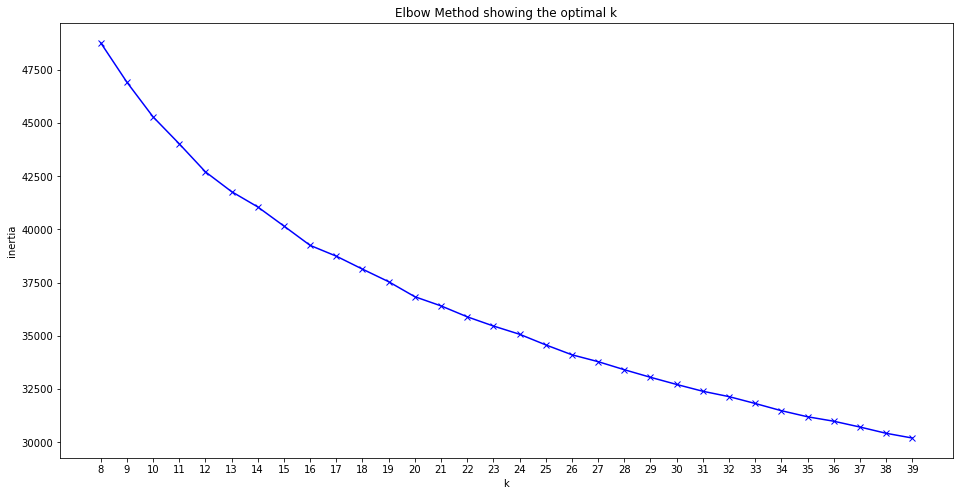

In [22]:
K = range(8, 40)
inertia = []

for k in K:
    print("Training a K-Means model with {} clusters! ".format(k))
    print()
    kmeans = KMeans(n_clusters=k,
                    random_state=345)
    kmeans.fit(X_scaled_df)
    inertia.append(kmeans.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

#### Silhouette Method

Text(0.5, 1.0, 'Silhouette Method showing the optimal k')

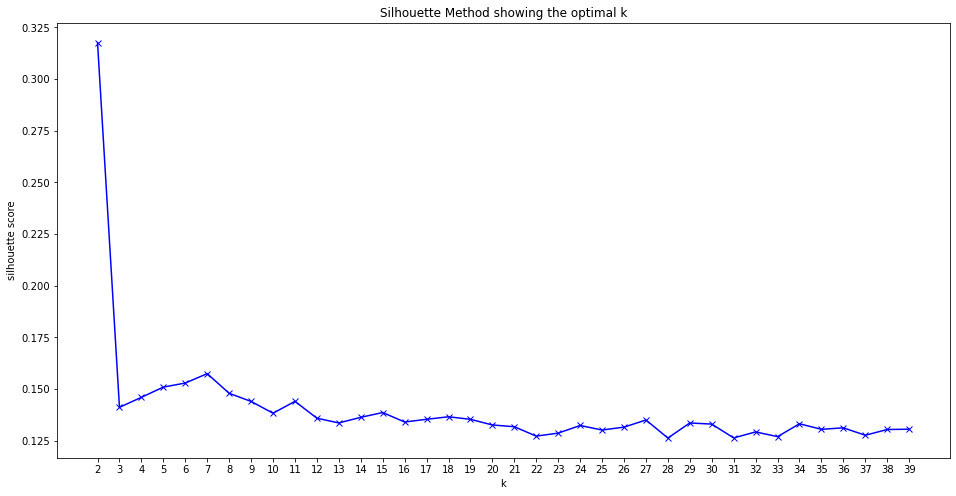

In [23]:
K = range(2, 40)
silhouette = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    n_init=50,
                    random_state=345)
    kmeans.fit(X_scaled_df)
    
    filename = "Model/kmeans_" + str(k) + ".pickle"
    with open(filename, "wb") as f:
        pickle.dump(kmeans,f)
    
    silhouette.append(silhouette_score(X_scaled_df, kmeans.predict(X_scaled_df)))


plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Silhouette Method showing the optimal k')

### Finalizing Database

In [34]:
# setting up clusters, using 27 based on Silhouette
kmeans = KMeans(n_clusters=27, random_state=345)
kmeans.fit(X_scaled_df)

KMeans(n_clusters=27, random_state=345)

In [35]:
kmeans.inertia_

33790.520735227714

In [36]:
clusters = kmeans.predict(X_scaled_df)
pd.Series(clusters).value_counts().sort_index()

0     237
1     435
2     343
3     155
4     266
5     329
6     332
7     540
8     163
9     285
10    307
11    323
12    571
13    257
14    274
15    338
16    304
17    269
18    388
19    528
20    115
21    199
22    552
23    193
24    300
25    167
26    367
dtype: int64

In [37]:
# integrating cluster into dataframe
upsampled_df['cluster'] = clusters

In [38]:
# saving the upsampled dataframe to a csv
from pathlib import Path  
filepath = Path('upsampled_df.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)
upsampled_df.to_csv(filepath, index=False)

In [39]:
# saving models
with open("Model/scaler.pickle", "wb") as f:
    pickle.dump(scaler,f)
with open("Model/kmeans.pickle", "wb") as f:
    pickle.dump(kmeans,f)